In [1]:
import tensorflow as tf
import numpy as np
import random, json, string, pickle
import keras
import keras.layers
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
import keras.models
from keras.models import Sequential
import keras.optimizers
import keras.callbacks
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

import keras.applications.vgg16 as vgg16

Using TensorFlow backend.


In [2]:
from bokeh.charts import Line
from bokeh.plotting import figure, show
from bokeh.models import Range1d
from bokeh.io import output_notebook
import bokeh as bokeh
output_notebook()
 
class LossTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.durations = []
        self.val_loss = []
    
    def on_epoch_begin(self, epoch, logs={}):
        import time
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        import time
        duration = time.time()-self.start_time
        self.durations.append(duration)  

Loading BokehJS ...

In [3]:
size_pantry = 500

In [5]:
# m = vgg16.VGG16(weights='imagenet')
# m.layers.pop()
# m.layers.append(Dense(size_pantry, activation='sigmoid'))
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# m.compile(loss='binary_crossentropy', optimizer = adam, metrics=['accuracy'])
# m.summary()

# get the pretrained model (minus FC layers)
original_model = vgg16.VGG16(weights='imagenet', include_top=False, input_tensor = vgg16.Input(shape=(224,224,3)))

# freeze conv layers
for layer in original_model.layers:
    layer.trainable = False
    #pass

# construct model
deep_features = Flatten()(original_model.output)
#fc1 = Dense(10, activation="relu")(deep_features)
ingredients_guessing = Dense(size_pantry, activation='sigmoid')(deep_features)#fc1)
m = keras.models.Model(input=original_model.input, output=ingredients_guessing)

print(m.summary())

optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True)
#optimizer = Adam()
m.compile(optimizer, loss='binary_crossentropy')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  0           input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  0           block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

Creating the Pantry

In [11]:
conn = sqlite3.connect("yummly.db")
recipes = conn.execute("SELECT ID, CleanIngredients FROM Recipe WHERE ImageAvailable=1 AND English=1;").fetchall()
conn.close()

In [12]:
def prepIngredients(ingredients_string):
    return [x.strip() for x in ingredients_string.split(";")]

recipes = [tuple([x[0], prepIngredients(x[1])])for x in recipes]

In [13]:
all_ingredients = np.array([item for sublist in recipes for item in sublist[1]])
unique_ing = np.unique(all_ingredients, return_counts = True)

argsort_results = np.argsort(unique_ing[1])

sorted_ing = unique_ing[0][argsort_results]
sorted_vals = unique_ing[1][argsort_results]
sorted_ing = sorted_ing[::-1]

id2food = sorted_ing[0:size_pantry]
food2id = {food: idx[0] for idx, food in np.ndenumerate(id2food)}



In [14]:
id2food[169]

'applesauce'

In [15]:
# free up some memory
all_ingredients = None
argsort_results = None
sorted_vals = None

In [16]:
ids = [] #[x[0] for x in recipes]
recipe_ingredients = [x[1] for x in recipes]
labels = [] #np.zeros([len(recipes), size_pantry])

class_frequency = [0] * size_pantry


# Then we build our training data. We're not going to include
# recipes that have ingredients not in the pantry
for i in range(0, len(recipes)):
    num_misses = 0
    current_recipe = [0] * size_pantry
    
    for j in range(0, len(recipe_ingredients[i])):
        if food2id.get(recipe_ingredients[i][j]) != None:
            food_id = food2id.get(recipe_ingredients[i][j])
            
            current_recipe[food_id] = 1
            class_frequency[food_id] = class_frequency[food_id] + 1
        else:
            num_misses = num_misses + 1
    
    if num_misses == 0 and sum(current_recipe) > 0:
        labels.append(current_recipe)
        ids.append(recipes[i][0])
            
    #labels[i, [food2id.get(x) for x in recipe_ingredients[i]]] = 1

In [17]:
recipe_ingredients = None
recipes = None

In [18]:
class_weights = [{index: len(ids) / x / 100} for index, x in enumerate(class_frequency)]


In [19]:
class_weights2 = [{index: np.power(5000 / x, 2)} for index, x in enumerate(class_frequency)]

In [20]:
len(labels[0])

500

In [5]:
pickle.dump( [ids, labels, food2id, id2food, class_weights, class_weights2], open( "ids_labels_nomissing_500.p", "wb" ) )

NameError: name 'ids' is not defined

In [4]:
[ids, labels, food2id, id2food, class_weights, class_weights2] = pickle.load( open( "ids_labels_nomissing_500.p", "rb" ) )

In [27]:
four_fifths = (len(labels) // 5) * 4

train_ids = ids[0:four_fifths]
train_labels = labels[0:four_fifths]

test_ids = ids[four_fifths:]
test_labels = labels[four_fifths:]

In [8]:
ids = None
labels = None

In [ ]:
train_ids[40]
#train_labels[40]

'3c89336a-cda7-44e7-b4f6-64eaf73c95b1'

In [6]:
m.load_weights('full_model_weights.hdf5')

In [ ]:
import random

# We need to rely on this because we can not load 50k images on memory at the same time.
def DataGenerator(imageIds, imageLabels, batch_size):
    batch = np.zeros((batch_size, 224, 224, 3))
    labels = np.zeros((batch_size, size_pantry))
    while True:
        batch_bad = False
        
        for i in range(0, batch_size):
            index = random.randint(0, len(imageIds) - 1)
            img_path = 'resized_thumbs/' + imageIds[index] + ".jpg"
            
            try:   
                #turns out a small number of our images are corrupted
                img = image.load_img(img_path, target_size=(224, 224))
            except:
                #print("Error reading image: " + imageIds[index])
                batch_bad = True
                
            
            img = image.img_to_array(img)
            batch[i, :, :, :] = img
            labels[i, :] = imageLabels[index]#, :]
        batch = vgg16.preprocess_input(batch)
        
        if batch_bad is False:
            #print(batch[10, :, :, 0])
            yield batch, labels
        

history = LossTimeHistory()
m.fit_generator(DataGenerator(train_ids, train_labels, 64), 64000, nb_epoch = 220,
                         validation_data = DataGenerator(test_ids, test_labels, 64),
                         nb_val_samples = 640,
                         nb_worker = 3,
                         max_q_size = 4,
                         pickle_safe = True,
                         class_weight = class_weights2,
                         callbacks = [history])

show(bokeh.models.layouts.Row(
    Line(data=history.losses, title='Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.val_loss, title='Validation Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.durations, title='Seconds Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='Seconds', xlabel='Epoch')))

m.save_weights('full_model_weights.hdf5')

Epoch 1/220
 6336/64000 [=>............................] - ETA: 659s - loss: 0.2927

In [11]:
show(bokeh.models.layouts.Row(
    Line(data=history.losses, title='Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.val_loss, title='Validation Loss Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='BCE', xlabel='Epoch'),
    Line(data=history.durations, title='Seconds Per Epoch', plot_width=390, plot_height=390, legend=None, ylabel='Seconds', xlabel='Epoch')))


In [60]:
batch_size = 16


generator_test_batch = np.zeros((batch_size, 224, 224, 3))
generator_test_labels = np.zeros((batch_size, size_pantry))

for i in range(0, batch_size):
    index = random.randint(0, len(train_ids) - 1)
    img_path = 'resized_thumbs/' + train_ids[index] + ".jpg"

    try:   
        #turns out a small number of our images are corrupted
        img = image.load_img(img_path, target_size=(224, 224))
    except:
        print("Error reading image: " + imageIds[index])
        batch_bad = True


    img = image.img_to_array(img)
    generator_test_batch[i, :, :, :] = img
    generator_test_labels[i, :] = train_labels[index]#, :]
generator_test_batch = vgg16.preprocess_input(generator_test_labels)

IndexError: too many indices for array

In [25]:
len(train_ids)

NameError: name 'train_ids' is not defined

f110e0f2-8022-43f7-acfc-1907cf34862f
('Strawberry Jam',)
Input image size: (1, 224, 224, 3)

Ground truth
sugar
lemon juice
strawberries

Top 10 Predictions
vanilla: 0.99831
sugar: 0.997189
strawberries: 0.89601
baking powder: 0.65331
flour: 0.286366
eggs: 0.125559
salt: 0.0418302
butter: 0.0244906
peanut butter: 0.0108668
lemon: 0.00771512


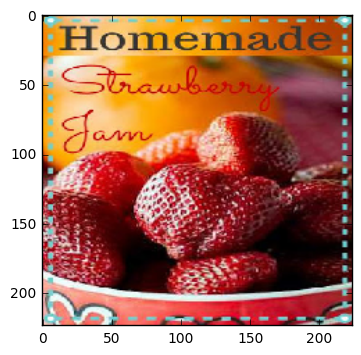

In [35]:
#img_path = 'download.jpg'  # This is an image I took in my kitchen.
j = random.randint(0,len(test_ids))
print(test_ids[j])
img_path = 'resized_thumbs/' + test_ids[j] + '.jpg'
#img_path = 'download3.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

predictions = m.predict(x)

#label_predictions = vgg16.decode_predictions(predictions, top = 10)

conn = sqlite3.connect("yummly.db")
print(conn.execute("SELECT Title FROM Recipe WHERE ID='" + str(test_ids[j]) + "';").fetchone())
conn.close()

print('Input image size:', x.shape)


plt.imshow(np.asarray(img));

print('\nGround truth') #with Prediction')
for i in range(0,size_pantry):
    if test_labels[j][i] == 1:
        print(id2food[i])# + ": " + str(predictions[0][i]))

argsort_results = np.argsort(-predictions)[0]


# print('\nAll Predictions over 10% certainty:')
# for i in range(0,size_pantry):
#     if predictions[0][i] > 0.1:
#         print(id2food[i] + ": " + str(predictions[0][i]))

print("\nTop 10 Predictions")
for i in range(0,10):
    #print(argsort_results[i])
    print(id2food[argsort_results[i]] + ": " + str(predictions[0][argsort_results[i]]))

In [ ]:
len(predictions)

## Predicting on the entirety of the validation set, to compute precision recall curve

In [117]:
test_predictions = np.zeros((len(test_ids), size_pantry))

for j in range(0, len(test_ids)):
    img_path = 'resized_thumbs/' + test_ids[j] + '.jpg'


    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    x = np.expand_dims(img_arr, axis=0)  # The model only accepts batches so we add a dummy dimension.
    x = vgg16.preprocess_input(x)  # The preprocessing should be the same that was used during training.

    test_predictions[j] = m.predict(x)
    
    if (j % 10000 == 0):
        print(str(j) + "...")


0...
10000...
20000...
30000...
40000...
50000...
60000...
70000...
80000...
90000...
100000...


In [ ]:
from sklearn.metrics import average_precision_score
for i in range(0, size_pantry):
    y_true = np.array(test_labels_np[:,i])
    y_scores = np.array(test_predictions[:,i])
    print(average_precision_score(y_true, y_scores)) 

In [ ]:
pickle.dump( [test_labels_np, test_], open( "test_labels_predictions.p", "wb" ) )

In [7]:
[test_labels_np, test_predictions] = pickle.load( open( "test_labels_predictions.p", "rb" ) )

In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(size_pantry):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_np[:, i],
                                                        test_predictions[:, i])
    average_precision[i] = average_precision_score(test_labels_np[:, i], test_predictions[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(test_labels_np.ravel(),
    test_predictions.ravel())
average_precision["micro"] = average_precision_score(test_labels_np, test_predictions,
                                                     average="micro")




In [ ]:
# Plot Precision-Recall curve
for i in range(0,size_pantry):
    plt.clf()
    plt.plot(recall[i], precision[i], lw=2, color='navy',
             label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1])
    plt.title('Precision-Recall, ' + id2food[i] + ': AUC={0:0.2f}'.format(average_precision[i]))
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         #shear_range=0.2,
#         #zoom_range=0.2,
#         horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# validation_generator = test_datagen.flow_from_directory(
#         'images/',
#         target_size=(224, 224),
#         batch_size=32,
#         class_mode=None)

# model.fit_generator(
#         train_generator,
#         samples_per_epoch=2000,
#         nb_epoch=50,
#         validation_data=validation_generator,
#         nb_val_samples=800)